In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Criação das funções para viabilizar a aplicação do modelo:

#### Função para instanciar o modelo:

In [2]:
from sklearn.svm import SVC

def instantiate_SVC_model (X_train, y_train):
    param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'sigmoid']}
    

    # Init classifier
    svc_cl = SVC()

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(svc_cl, param_grid, n_jobs = -1, cv=5, scoring = "roc_auc")

    # Fit 
    grid_cv.fit(X_train, y_train)

    mean_test_score = grid_cv.cv_results_['mean_test_score'].mean()
    std_test_score = grid_cv.cv_results_['std_test_score'].mean()
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    #print('')

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score'].mean()}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score'].mean()}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return mean_test_score, std_test_score, best_score, best_params

#### Criação de uma função para predição do classificador final:

In [3]:
from sklearn.svm import SVC

def create_final_cl(X_over, y_over, X_test, y_test, C, gamma, kernel):

    result_accuracy = []
    result_f1 = []
    result_precision = []
    result_recall = []
    result_roc_auc = []

    # parametrizando o modelo final
    final_cl = SVC(C=C, gamma=gamma, kernel=kernel)
    #final_cl = make_pipeline(StandardScaler(), SVC(C=C, gamma=gamma, kernel=kernel))

    #treinando o modelo final
    final_cl.fit(X_over, y_over)

    preds = final_cl.predict(X_test)

    accuracy_score(y_test, preds)

    print('"""Accuracy"""')
    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)
    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('macro: ', f1_score(y_test, preds, average='macro'))
    print('micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('macro: ', precision_score(y_test, preds, average='macro'))
    print('micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas recall_score:"""')
    print('Recall: ', recall_score(y_test, preds))
    print('macro: ', recall_score(y_test, preds, average='macro'))
    print('micro: ', recall_score(y_test, preds, average='micro'))
    print('weighted: ', recall_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""ROC_AUC Score:"""')
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    result_accuracy.append(accuracy_score(y_test, preds))

    result_f1.append(f1_score(y_test, preds))
    result_f1.append(f1_score(y_test, preds, average='macro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))
    result_f1.append(f1_score(y_test, preds, average='micro'))

    result_precision.append(precision_score(y_test, preds))
    result_precision.append(precision_score(y_test, preds, average='macro'))
    result_precision.append(precision_score(y_test, preds, average='micro'))
    result_precision.append(precision_score(y_test, preds, average='weighted'))

    result_recall.append(recall_score(y_test, preds))
    result_recall.append(recall_score(y_test, preds, average='macro'))
    result_recall.append(recall_score(y_test, preds, average='micro'))
    result_recall.append(recall_score(y_test, preds, average='weighted'))

    result_roc_auc.append(roc_auc_score(y_test, preds, multi_class='ovr'))

    return preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc

#### Criação de funções para plotagem de métricas:

In [4]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def plot_permutation_importance(final_cl, X_test, y_test):
    perm_importance = permutation_importance(final_cl, X_test, y_test)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.figure(figsize=(10,10))
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], height=0.8)
    plt.xlabel("Permutation Importance")
    plt.show()

#### Criação de uma função para aplicar o modelo para o período de tempo escolhido:

In [5]:
def apply_model (df):

    results_accuracy = []
    results_f1 = []
    results_precision = []
    results_recall = []
    results_roc_auc = []

    X = df.drop(labels=['death', 'data_notificacao'], axis=1)
    y = df['death']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .30)

    ####################################################
    #              APLICANDO O MODELO                  #
    ####################################################

    list_random_states = [42]

    mean_test_scores = []
    std_test_scores = []
    best_scores = []
    best_params = []

    for random_state in list_random_states:

        mean_test_score, std_test_score, best_score, best_param = mean_test_score, std_test_score, best_score, best_param = instantiate_SVC_model(X_train, y_train)

        mean_test_scores.append(mean_test_score)
        std_test_scores.append(std_test_score)
        best_scores.append(best_score)
        best_params.append(best_param)

    idx = best_scores.index(max(best_scores))
    best_param = best_params[idx]
    
    preds, final_cl, result_accuracy, result_f1, result_precision, result_recall, result_roc_auc = create_final_cl(X_train, y_train, X_test, y_test, best_param['C'], best_param['gamma'], best_param['kernel'])
            
    results_accuracy.append(result_accuracy)
    results_f1.append(result_f1)
    results_precision.append(result_precision)
    results_recall.append(result_recall)
    results_roc_auc.append(result_roc_auc)

    plot_conf_matrix (X_test, y_test, preds, final_cl)

    plot_roc_curve(y_test, preds)

    plot_permutation_importance(final_cl, X_test, y_test)

    return results_accuracy, results_f1, results_precision, results_recall, results_roc_auc

## Lendo o dataset:

In [6]:
df = pd.read_csv('..\..\Data\Casos Graves\df_casos_graves')

### Utilizando a class de pré-processamento para preparar o dataset:

In [7]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']
features = np.array(list_features)

In [8]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\maril\AppData\Local\Temp\ipykernel_10092\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.356522,0,1,2020-02-26
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-26
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.217391,1,0,2020-02-27
3,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-27
4,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.260870,1,0,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-12
36431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.556522,0,1,2022-06-12
36432,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2022-06-12
36433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-06-13


### Aplicação do modelo considerando a base de dados completa:

########################################

best_score: 0.7789405068660546
best_params_: {'C': 100, 'gamma': 1, 'kernel': 'linear'}
########################################

"""Accuracy"""
accuracy_score: 0.7464810821407567
########################################
"""Métricas f1_score:"""
f1:  0.09439775910364145
macro:  0.47350387157370355
micro:  0.7464810821407567
weighted:  0.6569701231407679
########################################
"""Métricas precision_score:"""
Precision:  0.6028622540250447
macro:  0.6762808023111674
micro:  0.7464810821407567
weighted:  0.7118112920777077
########################################
"""Métricas recall_score:"""
Recall:  0.0512080230967938
macro:  0.5197384440151058
micro:  0.7464810821407567
weighted:  0.7464810821407567
########################################
"""ROC_AUC Score:"""
roc_auc_score:  0.5197384440151058


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


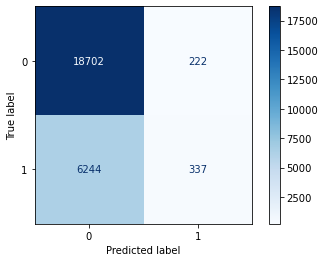

              precision    recall  f1-score   support

           0       0.75      0.99      0.85     18924
           1       0.60      0.05      0.09      6581

    accuracy                           0.75     25505
   macro avg       0.68      0.52      0.47     25505
weighted avg       0.71      0.75      0.66     25505

roc_auc_score:  0.5197384440151058


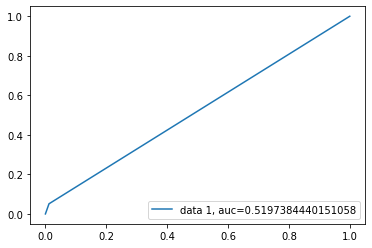

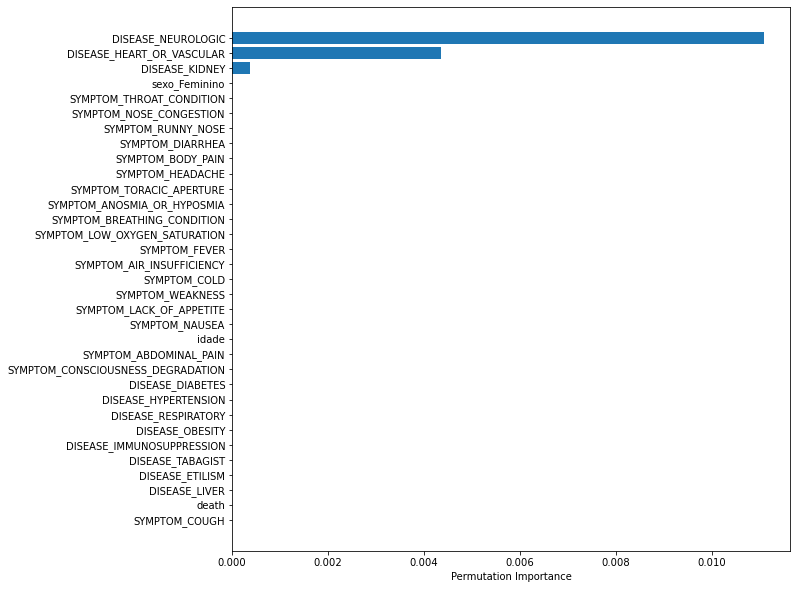

In [9]:
results_accuracy_all_svm, results_f1_all_svm, results_precision_all_svm, results_recall_all_svm, results_roc_auc_all_svm = apply_model(df)

### Lista com as métricas de cada período:

In [10]:
metricas_accuracy_all_svm = pd.DataFrame(results_accuracy_all_svm)
metricas_accuracy_all_svm.columns = ['accuracy score']
#metricas_accuracy_all_svm
metricas_f1_all_svm = pd.DataFrame(results_f1_all_svm)
metricas_f1_all_svm.columns = ['f1 score', 'f1 score macro', 'f1 score micro', 'f1 score weighted']
#metricas_f1_all_svm
metricas_precision_all_svm = pd.DataFrame(results_precision_all_svm)
metricas_precision_all_svm.columns = ['precision score', 'precision score macro', 'precision score micro', 'precision score weighted']
#metricas_precision_all_svm
metricas_recall_all_svm = pd.DataFrame(results_recall_all_svm)
metricas_recall_all_svm.columns = ['recall score', 'recall score macro', 'recall score micro', 'recall score weighted']
#metricas_recall_all_svm
metricas_roc_auc_all_svm = pd.DataFrame(results_roc_auc_all_svm)
metricas_roc_auc_all_svm.columns = ['roc_auc score']
#metricas_roc_auc_all_svm
metricas_all_svm = pd.concat([metricas_accuracy_all_svm, metricas_f1_all_svm, metricas_precision_all_svm, metricas_recall_all_svm, metricas_roc_auc_all_svm], axis=1)
metricas_all_svm


,accuracy score,f1 score,f1 score macro,f1 score micro,f1 score weighted,precision score,precision score macro,precision score micro,precision score weighted,recall score,recall score macro,recall score micro,recall score weighted,roc_auc score
0,0.746481,0.094398,0.473504,0.746481,0.746481,0.602862,0.676281,0.746481,0.711811,0.051208,0.519738,0.746481,0.746481,0.519738


In [11]:
list_periodos_all = [['26/02/2020 até 15/06/2022']]

In [12]:
coluna_periodosall = pd.DataFrame(list_periodos_all)
coluna_periodosall.columns = ['Períodos']
coluna_periodosall

,Períodos
0,26/02/2020 até 15/06/2022


In [13]:
metricas_all_svm_final = pd.concat([coluna_periodosall, metricas_all_svm], axis=1)
metricas_all_svm_final

,Períodos,accuracy score,f1 score,f1 score macro,f1 score micro,f1 score weighted,precision score,precision score macro,precision score micro,precision score weighted,recall score,recall score macro,recall score micro,recall score weighted,roc_auc score
0,26/02/2020 até 15/06/2022,0.746481,0.094398,0.473504,0.746481,0.746481,0.602862,0.676281,0.746481,0.711811,0.051208,0.519738,0.746481,0.746481,0.519738


In [14]:
metricas_all_svm_final.to_csv('metricas_all_svm_final.csv', index=False)